In [3]:
import cv2
import numpy as np
import mediapipe as mp
from skimage.feature import hog
import matplotlib.pyplot as plt

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

print("Libraries imported, and MediaPipe Face Mesh initialized!")

Libraries imported, and MediaPipe Face Mesh initialized!


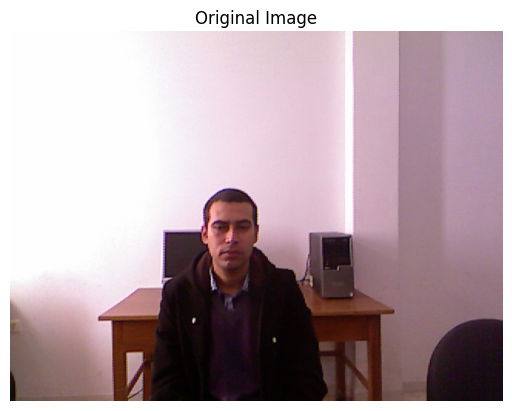

In [4]:
# Load example image
image_path = "C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one\\M01\\phrases\\10\\10\\color_001.jpg"  # Replace with the path to your image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [5]:
def resize_image(image, width=640):
    height = int(image.shape[0] * (width / image.shape[1]))
    return cv2.resize(image, (width, height))


Face detected!
Cropped mouth detected!


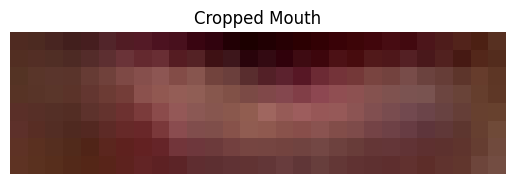

In [6]:
# Initialize Mediapipe Face Mesh globally
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

def detect_and_crop_mouth(image):
    try:
        # Resize image to prevent memory overload
        image_resized = resize_image(image)
        
        # Convert image to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        
        # Detect face landmarks
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
            print("Face detected!")
            
            for face_landmarks in results.multi_face_landmarks:
                mouth_indices = [
                    61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308,
                    324, 318, 402, 317, 14, 87, 178, 88, 95
                ]
                mouth_points = [
                    (
                        int(face_landmarks.landmark[i].x * image_resized.shape[1]),
                        int(face_landmarks.landmark[i].y * image_resized.shape[0])
                    )
                    for i in mouth_indices
                ]
                x_min = max(0, min([p[0] for p in mouth_points]))
                x_max = min(image_resized.shape[1], max([p[0] for p in mouth_points]))
                y_min = max(0, min([p[1] for p in mouth_points]))
                y_max = min(image_resized.shape[0], max([p[1] for p in mouth_points]))
                
                if x_max - x_min > 0 and y_max - y_min > 0:
                    cropped_mouth = image_resized[y_min:y_max, x_min:x_max]
                    print("Cropped mouth detected!")
                    return cropped_mouth
                else:
                    print("Invalid bounding box dimensions.")
                    return None
        else:
            print("No face detected.")
            return None
    except Exception as e:
        print(f"Error during processing: {e}")
        return None

# Test the function
image_path = "C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one\\M07\\phrases\\09\\10\\color_010.jpg"
image = cv2.imread(image_path)
cropped_mouth = detect_and_crop_mouth(image)
if cropped_mouth is not None:
    plt.imshow(cv2.cvtColor(cropped_mouth, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Mouth")
    plt.axis('off')
    plt.show()
else:
    print("No mouth detected.")

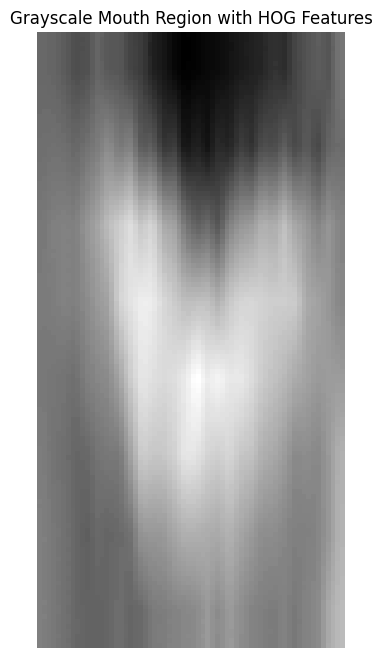

HOG Features Shape: (3780,)


In [7]:
def hog_transform(cropped_mouth):
    # Ensure the mouth image exists
    if cropped_mouth is None:
        print("No mouth region to transform.")
        return None
    
    # Convert the cropped mouth to grayscale (uint8 format)
    gray_mouth = cv2.cvtColor(cropped_mouth, cv2.COLOR_BGR2GRAY)

    # Resize the image to (64, 128), as it's a typical size for HOG features
    cropped_mouth_resized = cv2.resize(gray_mouth, (64, 128))  # Resize to (64, 128) for HOG
    
    # Ensure the image is in uint8 format
    cropped_mouth_resized = np.uint8(cropped_mouth_resized)
    
    # Initialize HOG descriptor
    hog_descriptor = cv2.HOGDescriptor()

    # Compute the HOG features
    hog_features = hog_descriptor.compute(cropped_mouth_resized)
    
    # Visualize the HOG image
    plt.figure(figsize=(8, 8))
    plt.imshow(cropped_mouth_resized, cmap='gray')
    plt.axis('off')
    plt.title("Grayscale Mouth Region with HOG Features")
    plt.show()
    
    return hog_features

# Apply HOG transformation
hog_features = hog_transform(cropped_mouth)
if hog_features is not None:
    print(f"HOG Features Shape: {hog_features.shape}")

In [14]:
import cv2
from skimage.feature import hog
import numpy as np
import os

def detect_and_crop_mouth(image):
    """Detect the mouth in the image and return the cropped mouth region."""
    # Define the path to the cascade files (update with your Downloads folder path)
    face_cascade_path = r"C:\Users\la7tim\Downloads\haarcascade_frontalface_default.xml"
    mouth_cascade_path = r"C:\Users\la7tim\Downloads\haarcascade_mcs_mouth.xml"

    # Check if the cascade files exist at the specified path
    if not os.path.exists(face_cascade_path):
        raise ValueError(f"Face cascade file not found at {face_cascade_path}")
    if not os.path.exists(mouth_cascade_path):
        raise ValueError(f"Mouth cascade file not found at {mouth_cascade_path}")

    # Load the cascades
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    mouth_cascade = cv2.CascadeClassifier(mouth_cascade_path)

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image (there should be only one face)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected!")
        return None

    # Assume we work with the first detected face
    x, y, w, h = faces[0]  # Coordinates of the face
    face_region = gray_image[y:y+h, x:x+w]

    # Detect mouth within the face region
    mouths = mouth_cascade.detectMultiScale(face_region, scaleFactor=1.1, minNeighbors=5)

    if len(mouths) == 0:
        print("No mouth detected!")
        return None

    # Assume the first mouth detected is the correct one
    mx, my, mw, mh = mouths[0]  # Coordinates of the mouth
    cropped_mouth = face_region[my:my+mh, mx:mx+mw]

    return cropped_mouth

def extract_hog_features(image):
    """Function to extract HOG features from an image."""
    resized_image = cv2.resize(image, (64, 64))  # Resize to a fixed size for feature extraction
    features, _ = hog(resized_image, visualize=True, block_norm='L2-Hys')
    return features

def process_image(image_path):
    """Process the image to extract HOG features from the mouth region."""
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    # Detect and crop mouth from the image
    cropped_mouth = detect_and_crop_mouth(image)

    if cropped_mouth is not None:
        # Extract HOG features from the cropped mouth
        hog_features = extract_hog_features(cropped_mouth)
        print(f"HOG Features Shape: {hog_features.shape}")
        return hog_features
    else:
        print("No valid mouth region found!")
        return None

# Example usage
image_path = r"C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\M01\phrases\10\10\color_001.jpg" 
hog_features = process_image(image_path)


HOG Features Shape: (2916,)


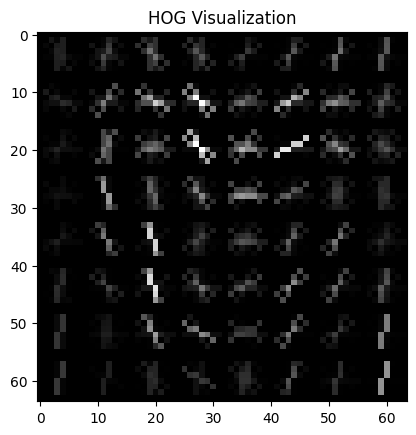

In [16]:
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.feature import hog
import cv2

# Visualize the HOG features
def visualize_hog(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:  # Check if the image has 3 channels (color)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize image to 64x64 for consistency
    resized_image = cv2.resize(image, (64, 64))

    # Extract HOG features and the visualization image
    features, hog_image = hog(resized_image, visualize=True, block_norm='L2-Hys')

    # Rescale the HOG image to improve visibility
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display the HOG image
    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.title("HOG Visualization")
    plt.show()

# Example usage: Visualize HOG features from the cropped mouth image
if cropped_mouth is not None:
    visualize_hog(cropped_mouth)


In [22]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from skimage import exposure

# Define paths for your dataset
base_dir = "C:/Users/la7tim/Downloads/MIRACL-VC1_all_in_one"

# Define the ID mappings for words/phrases
words_id = {
    1: "Begin", 2: "Choose", 3: "Connection", 4: "Navigation",
    5: "Next", 6: "Previous", 7: "Start", 8: "Stop",
    9: "Hello", 10: "Well"
}

phrases_id = {
    1: "Stop navigation.", 2: "Excuse me.", 3: "I am sorry.",
    4: "Thank you.", 5: "Good bye.", 6: "I love this game.",
    7: "Nice to meet you.", 8: "You are welcome.", 9: "How are you?",
    10: "Have a good time"
}

def detect_and_crop_mouth(image):
    """Detect the mouth in the image and return the cropped mouth region."""
    face_cascade_path = r"C:\Users\la7tim\Downloads\haarcascade_frontalface_default.xml"
    mouth_cascade_path = r"C:\Users\la7tim\Downloads\haarcascade_mcs_mouth.xml"

    if not os.path.exists(face_cascade_path):
        raise ValueError(f"Face cascade file not found at {face_cascade_path}")
    if not os.path.exists(mouth_cascade_path):
        raise ValueError(f"Mouth cascade file not found at {mouth_cascade_path}")

    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    mouth_cascade = cv2.CascadeClassifier(mouth_cascade_path)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected!")
        return None

    x, y, w, h = faces[0]
    face_region = gray_image[y:y+h, x:x+w]

    mouths = mouth_cascade.detectMultiScale(face_region, scaleFactor=1.1, minNeighbors=5)

    if len(mouths) == 0:
        print("No mouth detected!")
        return None

    mx, my, mw, mh = mouths[0]
    cropped_mouth = face_region[my:my+mh, mx:mx+mw]

    return cropped_mouth

def extract_hog_features(image):
    """Extract HOG features from an image."""
    resized_image = cv2.resize(image, (64, 64))
    features, _ = hog(resized_image, visualize=True, block_norm='L2-Hys')
    return features

def load_images_from_folder(base_dir):
    images = []
    labels = []
    
    if not os.path.isdir(base_dir):
        print(f"Base directory does not exist: {base_dir}")
        return images, labels
    
    # Iterate over each speaker directory
    for speaker_folder in os.listdir(base_dir):
        speaker_path = os.path.join(base_dir, speaker_folder)
        
        if not os.path.isdir(speaker_path):
            continue
        
        speaker_id = speaker_folder
        print(f"Processing Speaker: {speaker_id}")
        
        # Iterate over phrases and words folders
        for phrase_word in ['Phrases', 'Words']:
            phrase_word_path = os.path.join(speaker_path, phrase_word)
            
            if not os.path.isdir(phrase_word_path):
                print(f"Directory not found: {phrase_word_path}")
                continue
            
            # Iterate over Phrase or Word IDs
            for subfolder in os.listdir(phrase_word_path):
                subfolder_path = os.path.join(phrase_word_path, subfolder)
                
                if not os.path.isdir(subfolder_path):
                    continue
                
                print(f"Processing {phrase_word} ID: {subfolder}")
                
                # Process each instance folder within the Phrase/Word ID
                for instance_folder in os.listdir(subfolder_path):
                    instance_path = os.path.join(subfolder_path, instance_folder)
                    
                    if not os.path.isdir(instance_path):
                        continue
                    
                    # Process each image file in the instance folder
                    for image_name in os.listdir(instance_path):
                        if image_name.endswith(".jpg"):
                            image_path = os.path.join(instance_path, image_name)
                            print(f"Loading image: {image_path}")
                            image = cv2.imread(image_path)
                            
                            if image is not None:
                                # Detect and crop mouth region
                                cropped_mouth = detect_and_crop_mouth(image)
                                if cropped_mouth is not None:
                                    # Extract HOG features
                                    hog_features = extract_hog_features(cropped_mouth)
                                    images.append(hog_features)
                                    
                                    # Assign label based on phrase/word folder
                                    if phrase_word == 'Phrases':
                                        label = f"Phrase_{subfolder}"  # Example label format for phrases
                                    else:
                                        label = f"Word_{subfolder}"  # Example label format for words
                                    
                                    labels.append((speaker_id, label))
    
    return np.array(images), labels

# Load and process data
base_dir = "C:\\Users\\la7tim\\Downloads\\MIRACL-VC1_all_in_one"  # Replace with the actual base directory path
image_data, label_data = load_images_from_folder(base_dir)

# Check the results
print(f"Number of samples: {len(image_data)}")
print(f"Sample labels: {label_data[:5]}")


Processing Speaker: F01
Processing Phrases ID: 01
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_001.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_002.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_003.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_004.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_005.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_006.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_007.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_008.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_009.jpg
Loading image: C:\Users\la7tim\Downloads\MIRACL-VC1_all_in_one\F01\Phrases\01\01\color_010.jpg


In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Convert label_data to a NumPy array if it's a list
label_data = np.array(label_data)

# Extract labels from label_data
# Extract the second element of each tuple (the label) for use in classification
labels = np.array([label[1] for label in label_data])

# Check the shapes of your datasets
print("image_data shape:", image_data.shape)
print("labels shape:", labels.shape)

# Ensure both datasets have the same number of samples
if image_data.shape[0] != labels.shape[0]:
    raise ValueError("Mismatch in the number of samples between image_data and label_data")

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Check unique classes in y_train
print("Unique labels in y_train:", np.unique(y_train))

# If there is only one class in the training data, raise an error
if len(np.unique(y_train)) == 1:
    raise ValueError("Only one class present in the training data. Please ensure the dataset contains multiple classes.")

# Map string labels to integers (optional, for SVM)
unique_labels, y_train = np.unique(y_train, return_inverse=True)
y_test = np.array([np.where(unique_labels == label)[0][0] for label in y_test])

# Check the shape of y_train (should be 1D now)
print("y_train after conversion:", y_train.shape)

# Initialize and train the classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")


image_data shape: (32346, 2916)
labels shape: (32346,)
Unique labels in y_train: ['Phrase_01' 'Phrase_02' 'Phrase_03' 'Phrase_04' 'Phrase_05' 'Phrase_06'
 'Phrase_07' 'Phrase_08' 'Phrase_09' 'Phrase_10' 'Word_01' 'Word_02'
 'Word_03' 'Word_04' 'Word_05' 'Word_06' 'Word_07' 'Word_08' 'Word_09'
 'Word_10']
y_train after conversion: (25876,)
Model accuracy: 22.95%


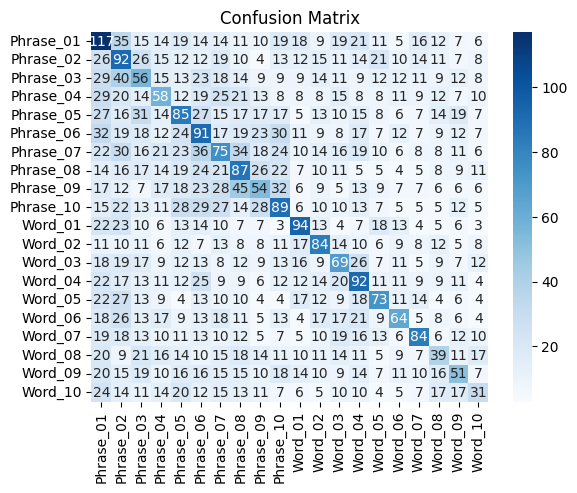

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.show()


In [47]:
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in y_train:", dict(zip(unique, counts)))


Class distribution in y_train: {0: 1636, 1: 1536, 2: 1395, 3: 1204, 4: 1252, 5: 1524, 6: 1530, 7: 1426, 8: 1256, 9: 1458, 10: 1124, 11: 1093, 12: 1279, 13: 1425, 14: 1057, 15: 1234, 16: 1044, 17: 1215, 18: 1172, 19: 1016}


In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_search = GridSearchCV(SVC(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Best model found by grid search
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Best model accuracy: {accuracy * 100:.2f}%")


Best model accuracy: 47.65%


In [50]:
# Best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [52]:
best_model = grid_search.best_estimator_


In [53]:
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort results by mean test score
sorted_results = results_df.sort_values(by="mean_test_score", ascending=False)

# Display top 5 parameter combinations
print(sorted_results[['params', 'mean_test_score', 'std_test_score']].head())


                                             params  mean_test_score  \
9      {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.427423   
5       {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.330925   
4    {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}         0.207567   
6     {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}         0.207567   
0  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}         0.207026   

   std_test_score  
9        0.006082  
5        0.006071  
4        0.009266  
6        0.009266  
0        0.008122  


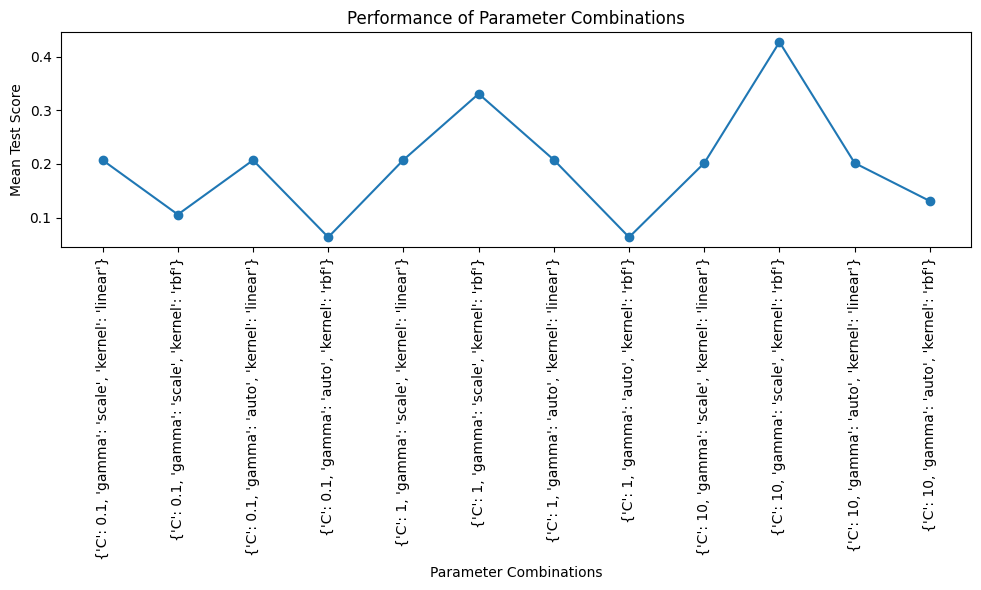

In [54]:
import matplotlib.pyplot as plt

# Extract parameter combinations and mean test scores
params = results_df["params"]
mean_scores = results_df["mean_test_score"]

# Plot the scores for each parameter combination
plt.figure(figsize=(10, 6))
plt.plot(range(len(params)), mean_scores, marker='o')
plt.xticks(range(len(params)), params, rotation=90)
plt.xlabel("Parameter Combinations")
plt.ylabel("Mean Test Score")
plt.title("Performance of Parameter Combinations")
plt.tight_layout()
plt.show()
